In [1]:
# baseado no exemplo em https://docs.simpeg.xyz/content/tutorials/04-magnetics/plot_2a_magnetics_induced.html

In [2]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from discretize import TensorMesh
from discretize.utils import mkvc
from SimPEG.utils import plot2Ddata, model_builder, surface2ind_topo
from SimPEG import maps
from SimPEG.potential_fields import magnetics
from SimPEG import utils, data

from copy import deepcopy
import fatiando.gravmag.transform as tr

E:\@ UFU 2021\Disciplinas\2021-01 REF 2020-01\demoaulas\Geofisica2\fatiando\vis\mpl.py:69: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "matplotlib.pyplot module directly. Some of the fatiando " +


In [3]:
class modelo():
    
    """
    Define as dimensões, topografia e malha de tensores do modelo
    """
    
    def __init__(self, par_x, par_y, par_z, topografia=None):
        
        """
        par_x:    parâmetros de comprimento e discretização do eixo x do modelo
        par_y:    parâmetros de comprimento e discretização do eixo y do modelo
        par_z:    parâmetros de comprimento e discretização do eixo z do modelo
        rho_bg:   densidade do background homogêneo
        """
        
        # cria os eixos x, y e z do modelo
        self.xx_m = np.linspace(-1 * par_x[0]/2, par_x[0]/2, 1 + int(par_x[0]/par_x[1]))
        self.yy_m = np.linspace(-1 * par_y[0]/2, par_y[0]/2, 1 + int(par_y[0]/par_y[1]))
        self.zz_m = np.linspace(0.0, par_z[0], 1 + int(par_z[0]/par_z[1]))
        
        
        # densidade das rochas do background - é zero porque o modelo vai considerar só
        # o contraste, não o valor absoluto
        self.suscep_background = 0.0001
        
        
        # Define a topografia do modelo
        [x_topo, y_topo] = np.meshgrid(self.xx_m, self.yy_m)
        if topografia=='default':
            z_topo = -15.0 * np.exp(-(x_topo ** 2 + y_topo ** 2) / 80 ** 2)

        elif not topografia:
            z_topo = np.zeros((len(self.yy_m), len(self.xx_m)))

        x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
        self.xyz_topo = np.c_[x_topo, y_topo, z_topo]


        # Define a malha de tensores em células de tamanho regular
        dx = self.xx_m[1]-self.xx_m[0]
        dy = self.yy_m[1]-self.yy_m[0]
        dz = self.zz_m[1]-self.zz_m[0]

        nx = int((np.max(self.xx_m)-np.min(self.xx_m))/dx)
        ny = int((np.max(self.yy_m)-np.min(self.yy_m))/dy)
        nz = int((np.max(self.zz_m)-np.min(self.zz_m))/dz)
        
        hx = [(dx, nx)]
        hy = [(dy, ny)]
        hz = [(dz, nz)]

        self.mesh = TensorMesh([hx, hy, hz], 'CCN')
        
        # Find the indices for the active mesh cells (e.g. cells below surface)
        self.ind_active = surface2ind_topo(self.mesh, self.xyz_topo)

        # Define mapping from model to active cells. The model consists of a value for
        # each cell below the Earth's surface.
        nC = int(self.ind_active.sum())
        self.model_map = maps.IdentityMap(nP=nC)

        # Define o modelo com a densidade do background. Models in SimPEG are vector arrays.
        self.model = self.suscep_background * np.ones(nC)
        
        
    def insere_esfera(self, chi, x, y, z, raio):
        ind_sphere = model_builder.getIndicesSphere([x, y, (z-raio)], raio, self.mesh.gridCC)
        ind_sphere = ind_sphere[self.ind_active]
        self.model[ind_sphere] = chi
        
        
    def insere_bloco(self, chi, vertices):
        """
        vertices: lista de tuplas -> [(xi, xf),(yi, yf),(zi, zf)]
        """
        
       
        ind_block = ((self.mesh.gridCC[self.ind_active, 0] > vertices[0][0])
                    & (self.mesh.gridCC[self.ind_active, 0] < vertices[0][1])
                    & (self.mesh.gridCC[self.ind_active, 1] > vertices[1][0])
                    & (self.mesh.gridCC[self.ind_active, 1] < vertices[1][1])
                    & (self.mesh.gridCC[self.ind_active, 2] > vertices[2][0])
                    & (self.mesh.gridCC[self.ind_active, 2] < vertices[2][1]))
        self.model[ind_block] = chi

    
    def plota_corte(self, direcao, posicao):

        if direcao.upper()=='X':
            indice_slice = np.abs(posicao - self.xx_m).argmin()
        
        if direcao.upper()=='Y':
            indice_slice = np.abs(posicao-self.yy_m).argmin()
            
        if direcao.upper()=='Z':
            indice_slice = np.abs((np.max(np.abs(self.zz_m))-np.abs(posicao))-self.zz_m).argmin()
        
        fig = plt.figure(figsize=(10, 3))
        plotting_map = maps.InjectActiveCells(self.mesh, self.ind_active, np.nan)

        ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
        
        self.mesh.plot_slice(
            plotting_map * self.model,
            normal=direcao,
            ax=ax1,
            ind=int(indice_slice),    # ind=int(self.mesh.nCy / 2),
            grid=True,
            clim=(np.min(self.model), np.max(self.model)),
            pcolorOpts={"cmap": "viridis"},
        )
        
        ax1.set_title('Corte em ' + direcao.upper() + ' = ' + str(posicao) + ' m')
        
        if direcao=='Y':
            ax1.set_xlabel('Distância em X (m)', fontsize=14)
            ax1.set_ylabel('Profundidade (m)', fontsize=14)
            
        elif direcao=='X':
            ax1.set_xlabel('Distância em Y (m)', fontsize=14)
            ax1.set_ylabel('Profundidade (m)', fontsize=14)
            
        elif direcao=='Z':
            ax1.set_xlabel('Distância em X (m)', fontsize=14)
            ax1.set_ylabel('Distância em Y (m)', fontsize=14)

        ax2 = fig.add_axes([0.85, 0.12, 0.025, 0.78])
        norm = mpl.colors.Normalize(vmin=np.min(self.model), vmax=np.max(self.model))
        cbar = mpl.colorbar.ColorbarBase(
            ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
        )
        cbar.set_label(r"$\chi \: (SI)$", rotation=90, labelpad=15, size=12)

        plt.show()

In [4]:
class aquisicao():
    
    def __init__(self, xx_s, yy_s, h_s, mod, f, inc, dec, componente=['tmi']):
    
        """
        Configura os pontos do levantamento no modelo
        
        The user only needs an (N, 3) array to define the xyz locations of the observation locations, 
        and a list of field components which are to be measured.
        
        xx_s:    coordenadas x dos pontos de levantamento
        yy_s:    coordenadas y dos pontos de levantamento
        h_s:     elevação do levantamento
        mod:     objeto da classe modelo
        """
        
        self.xx_s = xx_s
        self.yy_s = yy_s
        self.h_s = h_s
        self.componente = componente
        
        x, y = np.meshgrid(xx_s, yy_s)

        x = mkvc(x.T)
        y = mkvc(y.T)

        # cria a função de interpolação para o espaço do modelo
        fun_interp = LinearNDInterpolator(np.c_[mod.xyz_topo[:, 0], mod.xyz_topo[:, 1]], mod.xyz_topo[:, 2])

        # interpola as coordenadas das estações e coloca h_s metros acima da superfície
        z = fun_interp(np.c_[x, y]) + h_s
        
        self.receiver_locations = np.c_[x, y, z]

        # Use the observation locations and components to define the receivers. To
        # simulate data, the receivers must be defined as a list.
        receiver_list = magnetics.receivers.Point(self.receiver_locations, components=componente)
        self.receiver_list = [receiver_list]

        # Define the inducing field H0 = (intensity [nT], inclination [deg], declination [deg])
        inclination = inc
        declination = dec
        strength = f
        self.inducing_field = (strength, inclination, declination)
        self.source_field = magnetics.sources.SourceField(receiver_list=self.receiver_list, parameters=self.inducing_field)

        # Defining the survey
        self.survey = magnetics.survey.Survey(self.source_field)    # é um objeto
        
        
    def fwd(self, mod):
        
        # Define the forward simulation. By setting the 'store_sensitivities' keyword
        # argument to "forward_only", we simulate the data without storing the sensitivities
        simulation = magnetics.simulation.Simulation3DIntegral(
                        survey = self.survey,
                        mesh = mod.mesh,
                        chiMap = mod.model_map,
                        actInd = mod.ind_active,
                        store_sensitivities = "forward_only",
        )

        # Compute predicted data for some model
        self.dpred = simulation.dpred(mod.model)
        self.descricao = 'Intensidade Total (TMI)'
       
        
    def plota_mapa(self, coordenadas=[0.0, 0.0]):
        nx = len(self.xx_s)
        ny = len(self.yy_s)

        matriz_dados = np.reshape(self.dpred, [ny, nx])
        ind_x = np.abs(self.xx_s-coordenadas[0]).argmin()    # índice da coordenada x no eixo x
        ind_y = np.abs(self.yy_s-coordenadas[1]).argmin()    # índice da coordenada y no eixo y

        fig = plt.figure(figsize=(13, 6))

        plt.subplot(121)
        im = plt.imshow(np.flipud(matriz_dados), extent=[self.xx_s[0], self.xx_s[-1], self.yy_s[0], self.yy_s[-1]], \
                        cmap='jet_r', vmin=np.min(matriz_dados), vmax=np.max(matriz_dados), interpolation='bicubic')
        plt.plot([coordenadas[0], coordenadas[0]], [self.xx_s[0], self.xx_s[-1]], '--w')
        plt.plot([self.yy_s[0], self.yy_s[-1]], [coordenadas[1], coordenadas[1]], '--w')
        plt.colorbar(im, label='nT', shrink=0.75)
        plt.xlabel('Distância em X (m)', fontsize=14)
        plt.ylabel('Distância em Y (m)', fontsize=14)
        plt.title(self.descricao, fontsize=14)
        
        # para excluir os efeitos de borda da modelagem
        l_x = self.xx_s[-1] - self.xx_s[0]
        l_y = self.yy_s[-1] - self.yy_s[0]
        plt.xlim([self.xx_s[0]+(l_x/7), self.xx_s[-1]-(l_x/7)])
        plt.ylim([self.xx_s[0]+(l_x/7), self.xx_s[-1]-(l_x/7)])
        
        plt.subplot(222)
        plt.plot(self.yy_s, matriz_dados[:, ind_x])
        plt.title('Perfil cruzando a anomalia em X='+ str(coordenadas[0]) +' m', fontsize=14)
        plt.xlabel('Distância em Y (m)', fontsize=14)
        plt.ylabel('Anomalia (nT)', fontsize=14)
        plt.xlim([self.xx_s[0]+(l_x/7), self.xx_s[-1]-(l_x/7)])
        plt.grid()

        plt.subplot(224)
        plt.plot(self.xx_s, matriz_dados[ind_y,:])
        plt.title('Perfil cruzando a anomalia em Y='+ str(coordenadas[1]) +' m', fontsize=14)
        plt.xlabel('Distância em X (m)', fontsize=14)
        plt.ylabel('Anomalia (nT)', fontsize=14)
        plt.xlim([self.xx_s[0]+(l_x/7), self.xx_s[-1]-(l_x/7)])
        plt.grid()

        plt.tight_layout()
        plt.show()

In [5]:
def continuacao(survey_in, z):
    
    survey_out = deepcopy(survey_in)
    
    nx = len(survey_out.xx_s)
    ny = len(survey_out.yy_s)
    survey_out.dpred = tr.upcontinue(survey_out.xx_s, survey_out.yy_s, survey_out.dpred, (nx, ny), z)   #.reshape([ny, nx])
    survey_out.descricao = 'continuação p/ cima em ' + str(z) + ' m'
    
    return survey_out


def derivada_y(survey_in, ordem=1):
    
    survey_out = deepcopy(survey_in)
    
    nx = len(survey_out.xx_s)
    ny = len(survey_out.yy_s)
    survey_out.dpred = tr.derivx(survey_out.xx_s, survey_out.yy_s, survey_out.dpred, (nx, ny), order=ordem)    #.reshape([ny, nx])
    survey_out.descricao = str(int(ordem)) + 'a Derivada horizontal Y'
    
    return survey_out


def derivada_x(survey_in, ordem=1):
    
    survey_out = deepcopy(survey_in)
    
    nx = len(survey_out.xx_s)
    ny = len(survey_out.yy_s)
    survey_out.dpred = tr.derivy(survey_out.xx_s, survey_out.yy_s, survey_out.dpred, (nx, ny), order=ordem)    #.reshape([ny, nx])
    survey_out.descricao = str(int(ordem)) + 'a Derivada horizontal X'
    
    return survey_out


def derivada_z(survey_in, ordem=1):
    
    survey_out = deepcopy(survey_in)
    
    nx = len(survey_out.xx_s)
    ny = len(survey_out.yy_s)
    survey_out.dpred = tr.derivz(survey_out.xx_s, survey_out.yy_s, survey_out.dpred, (nx, ny), order=ordem)    #.reshape([ny, nx])
    survey_out.descricao = str(int(ordem)) + 'a Derivada vertical'
    
    return survey_out


def gradiente_total(survey_in):
    
    survey_out = deepcopy(survey_in)
    
    nx = len(survey_out.xx_s)
    ny = len(survey_out.yy_s)
    survey_out.dpred = tr.tga(survey_out.xx_s, survey_out.yy_s, survey_out.dpred, (nx, ny))    #.reshape([ny, nx])
    survey_out.descricao = 'Amplitude do gradiente total'
    
    return survey_out


def derivada_tilt(survey_in):
    
    survey_out = deepcopy(survey_in)
    
    nx = len(survey_out.xx_s)
    ny = len(survey_out.yy_s)
    survey_out.dpred = tr.tilt(survey_out.xx_s, survey_out.yy_s, survey_out.dpred, (nx, ny))    #.reshape([ny, nx])
    survey_out.descricao = 'Derivada tilt'
    
    return survey_out


def residual(survey_in_total, survey_in_regional):
    
    survey_out = deepcopy(survey_in_total)
    survey_out.dpred = survey_in_total.dpred - survey_in_regional.dpred
    survey_out.descricao = 'Campo residual'
    
    return survey_out


def red_polo(survey_in, inc, dec):
    
    survey_out = deepcopy(survey_in)
    
    nx = len(survey_out.xx_s)
    ny = len(survey_out.yy_s)
    
    sinc, sdec = [inc, dec]   # considera que não há magnetização remanente na fonte da anomalia
    
    survey_out.dpred = tr.reduce_to_pole(survey_out.xx_s, survey_out.yy_s, survey_out.dpred, (nx, ny), \
                                        inc, dec, sinc, sdec)
    
    survey_out.descricao = 'Redução ao Polo'
    
    return survey_out

In [6]:
eixo_x = [2000.0, 40.0]      # [comprimento, delta]
eixo_y = [2000.0, 40.0]      # [comprimento, delta]
eixo_z = [260.0, 20.0]       # [comprimento, delta]

In [7]:
meu_modelo = modelo(eixo_x, eixo_y, eixo_z)

In [8]:
# corpo esférico (chi, x_centro, y_centro, z_topo, raio)
meu_modelo.insere_esfera(0.01, -300.0, -300.0, -50.0, 120)

# corpo cúbico (delta_rho, [(xi, xf),(yi, yf),(zi, zf)])
meu_modelo.insere_bloco(0.01, [(-450, -150), (150, 450), (-200, -50)])

# dique na direção N-S (delta_rho, [(xi, xf),(yi, yf),(zi, zf)])
meu_modelo.insere_bloco(0.01, [(200, 300), (-1000, 1000), (-260, -140)])


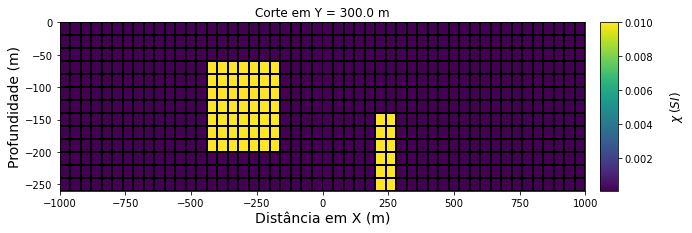

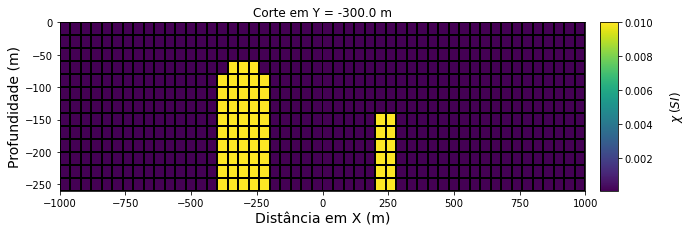

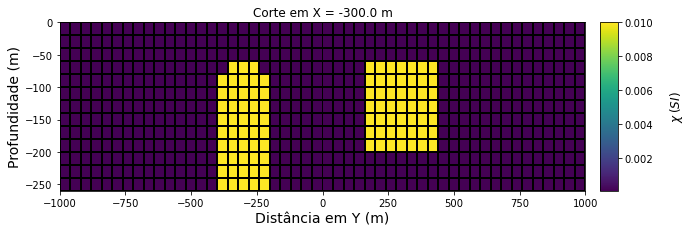

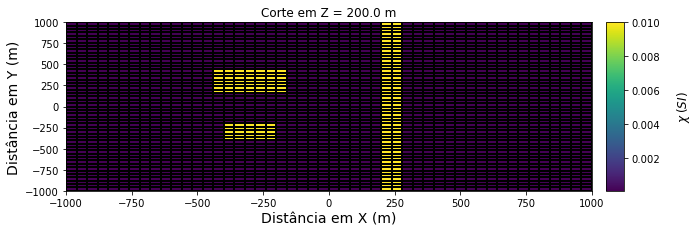

In [9]:
meu_modelo.plota_corte('Y', 300.0)
meu_modelo.plota_corte('Y', -300.0)
meu_modelo.plota_corte('X', -300.0)
meu_modelo.plota_corte('Z', 200.0)

In [10]:
x_rx = np.linspace(-1000, 1000.0, 40)
y_rx = np.linspace(-1000.0, 1000.0, 40)
h_rx = 0.0

minha_aquisicao = aquisicao(x_rx, y_rx, h_rx, meu_modelo, f=23177.7, inc=-35.9195, dec=-22.2848)

%time minha_aquisicao.fwd(meu_modelo)

Wall time: 3min 35s


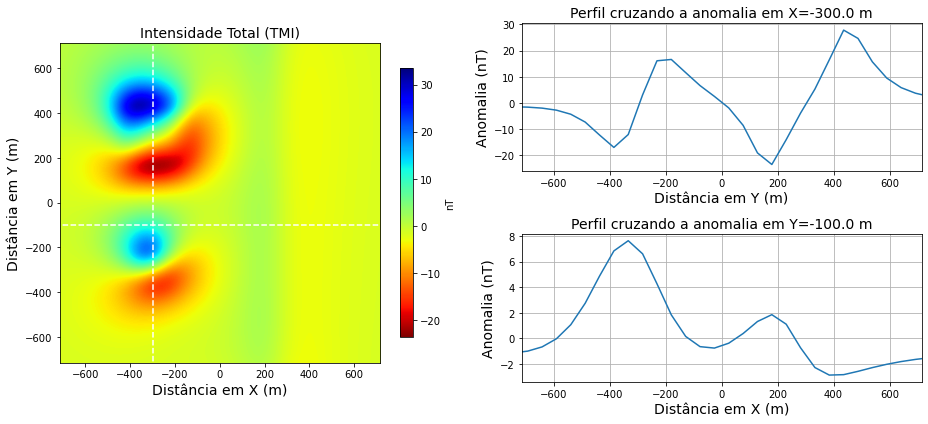

In [11]:
minha_aquisicao.plota_mapa([-300.0, -100.0])

# Transformações do campo

### continuação para cima

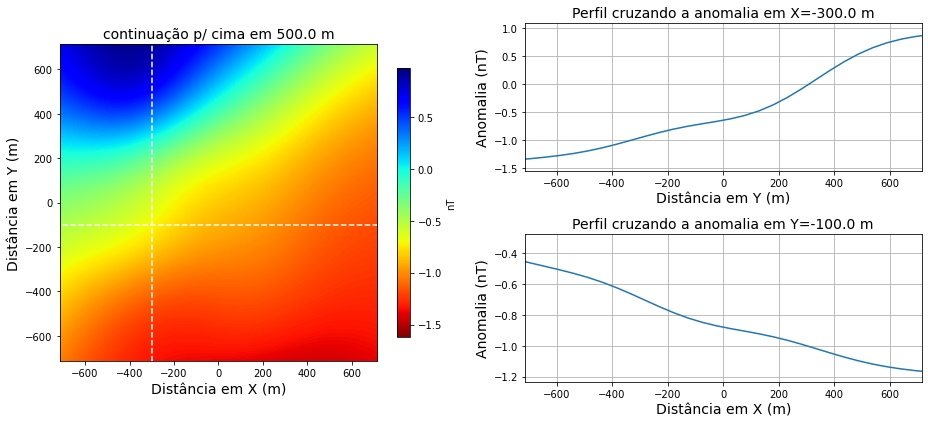

In [12]:
alt = 500.0        # altura da continuação (em metros)

minha_aquisicao_up = continuacao(minha_aquisicao, alt)
minha_aquisicao_up.plota_mapa([-300.0, -100.0])

### Residual

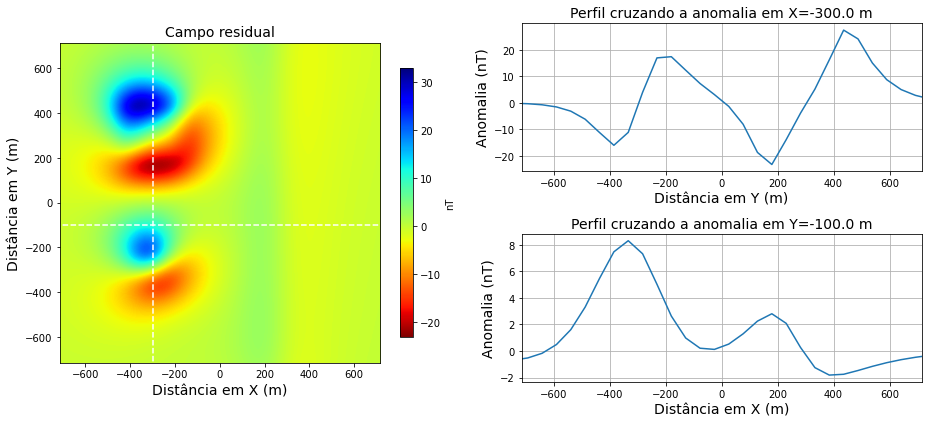

In [13]:
minha_aquisicao_res = residual(minha_aquisicao, minha_aquisicao_up)
minha_aquisicao_res.plota_mapa([-300.0, -100.0])

### redução ao polo

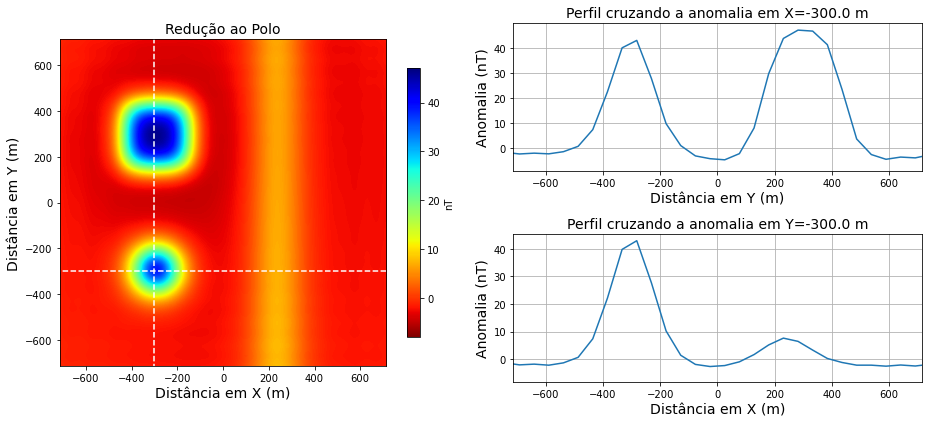

In [14]:
minha_aquisicao_rtp = red_polo(minha_aquisicao, inc=-35.9195, dec=-22.2848)
minha_aquisicao_rtp.plota_mapa([-300.0, -300.0])

### 2a derivada vertical

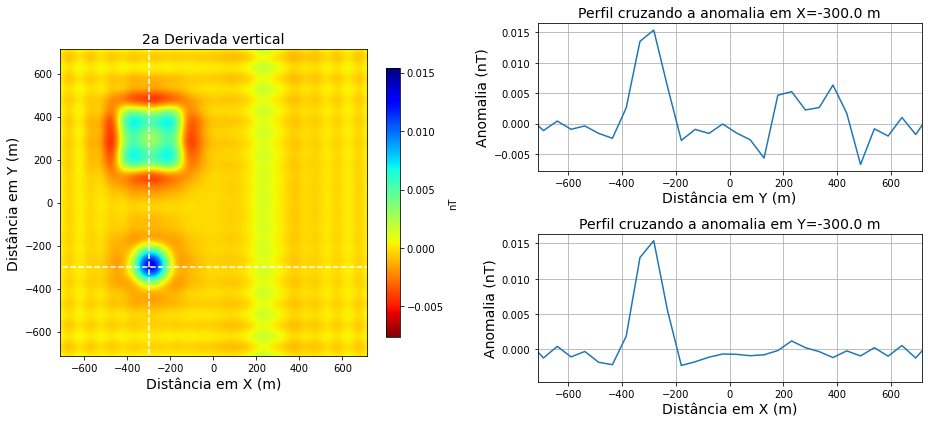

In [18]:
minha_aquisicao_dz2 = derivada_z(minha_aquisicao_rtp, ordem=2)
minha_aquisicao_dz2.plota_mapa([-300.0, -300.0])

### TGA

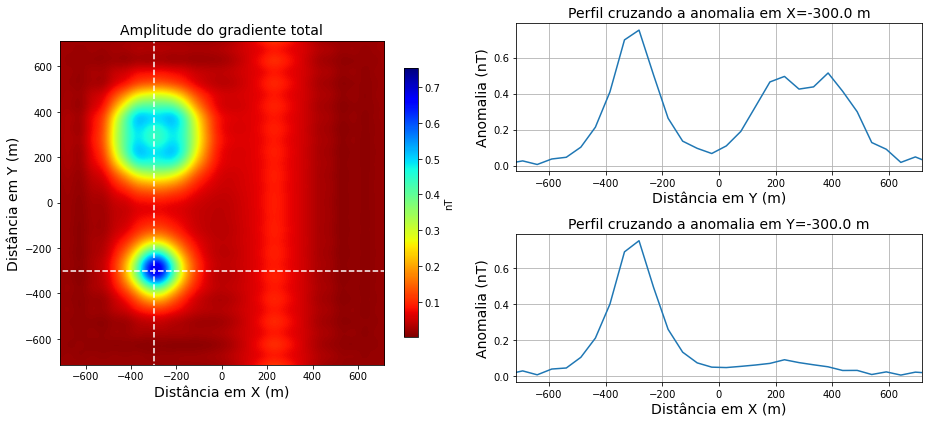

In [19]:
minha_aquisicao_tga = gradiente_total(minha_aquisicao_rtp)
minha_aquisicao_tga.plota_mapa([-300.0, -300.0])

### tilt derivative

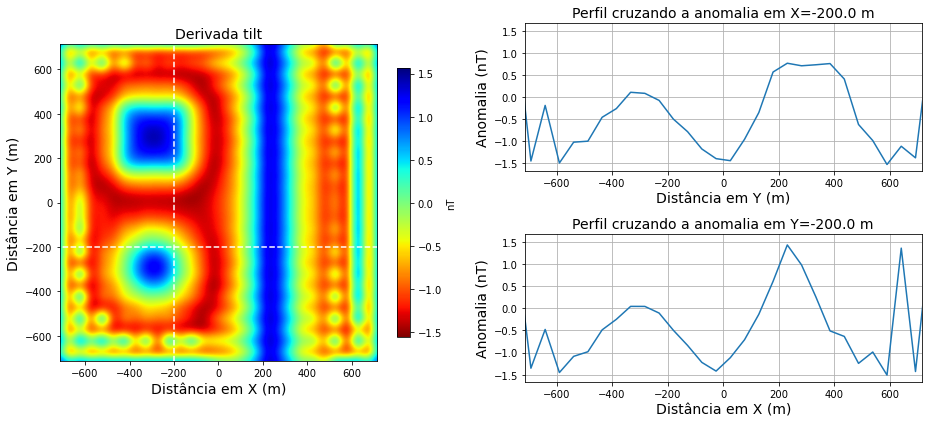

In [20]:
minha_aquisicao_tilt = derivada_tilt(minha_aquisicao_rtp)
minha_aquisicao_tilt.plota_mapa([-200.0, -200.0])